In [40]:
import pyarrow
import pyarrow.plasma as plasma
import numpy as np
import timeit
import time
import pickle
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
NUM_STRINGS = 2*10**5
STRING_LENGTH = 20
numpy_array_1 = np.array([1,2,3,4,5])
numpy_array_2 = np.array([i for i in range(10)])
numpy_array_3 = np.array([i for i in range(100)])
numpy_array_4 = np.array([i for i in range(1000)])
numpy_array_5 = np.array([i for i in range(10000)])
numpy_array_6 = np.array([i for i in range(100000)])
#numpy_array_2 = np.array([i for i in range(NUM_STRINGS)])
very_large_numpy_array = np.array([i for i in range(NUM_STRINGS * 10)])

### Run plasma store with `plasma_store -m 10000000 -s /tmp/plasma` (allocated 10MB of storage)

In [64]:
plasma_client = plasma.connect("/tmp/plasma", "", 0)

In [43]:
serialization_context = pyarrow._default_serialization_context
#set pickle and pytorch statements here?

In [46]:
t_start = time.time()
plasma_client.put(numpy_array_1)
t_end = time.time()
print t_end - t_start

0.000817060470581


In [47]:
t_start = time.time()
plasma_client.put(numpy_array_6)
t_end = time.time()
print t_end - t_start

0.00284385681152


### testing the plasma put function line by line

In [57]:
def line_testing_pyarrow_put(arr):
    line_times = {'serialize': [],
                  'oid_select' : [],
                  'buffer_create': [],
                  'init_buffer': [],
                  'write_stream': [],
                  'total': []}
    for i in range(10):
        t_total_start = time.time()

        t_start = time.time()
        serialized = pyarrow.serialize(arr, serialization_context)
        t_end = time.time()
        line_times['serialize'].append(t_end - t_start)

        t_start = time.time()
        target_id = plasma.ObjectID(str(np.random.randint(100000)))
        t_end = time.time()
        line_times['oid_select'].append(t_end - t_start)

        t_start = time.time()
        buffer = plasma_client.create(target_id, serialized.total_bytes)
        t_end = time.time()
        line_times['buffer_create'].append(t_end - t_start)

        t_start = time.time()
        stream = pyarrow.FixedSizeBufferWriter(buffer)
        t_end = time.time()
        line_times['init_buffer'].append(t_end - t_start)

        t_start = time.time()
        serialized.write_to(stream)
        t_end = time.time()
        line_times['write_stream'].append(t_end - t_start)

        t_total_end = time.time()
        line_times['total'].append(t_total_end - t_total_start)
        
    for item in line_times:
        num = reduce(lambda x, y: x + y, line_times[item]) / float(len(line_times[item]))
        line_times[item] = num
        
    print "serialization time: " + '\t' + '\t' + str(line_times['serialize'])
    print "oid selection time: " + '\t' + '\t' + str(line_times['oid_select'])
    print "buffer creation time: " + '\t' + '\t' + str(line_times['buffer_create'])
    print "initialize buffer writer time: " + '\t' + str(line_times['init_buffer'])
    print "write to stream time: " + '\t' + '\t' + str(line_times['write_stream'])
    print "total pyarrow put time: " + '\t' + str(line_times['total'])
    
    return line_times

In [65]:
arr_1_times = line_testing_pyarrow_put(numpy_array_1)

serialization time: 		8.23259353638e-05
oid selection time: 		1.95741653442e-05
buffer creation time: 		0.000270557403564
initialize buffer writer time: 	5.57899475098e-06
write to stream time: 		3.85284423828e-05
total pyarrow put time: 	0.000424718856812


In [66]:
arr_2_times = line_testing_pyarrow_put(numpy_array_2)

serialization time: 		6.97135925293e-05
oid selection time: 		2.43425369263e-05
buffer creation time: 		0.000211000442505
initialize buffer writer time: 	4.41074371338e-06
write to stream time: 		2.97069549561e-05
total pyarrow put time: 	0.000345587730408


In [67]:
arr_3_times = line_testing_pyarrow_put(numpy_array_3)

serialization time: 		7.34806060791e-05
oid selection time: 		2.80141830444e-05
buffer creation time: 		0.000244045257568
initialize buffer writer time: 	5.19752502441e-06
write to stream time: 		3.71932983398e-05
total pyarrow put time: 	0.000395178794861


In [68]:
arr_4_times = line_testing_pyarrow_put(numpy_array_4)

serialization time: 		7.66754150391e-05
oid selection time: 		2.09331512451e-05
buffer creation time: 		0.000312089920044
initialize buffer writer time: 	5.69820404053e-06
write to stream time: 		4.50611114502e-05
total pyarrow put time: 	0.000467157363892


In [69]:
arr_5_times = line_testing_pyarrow_put(numpy_array_5)

serialization time: 		8.10384750366e-05
oid selection time: 		2.281665802e-05
buffer creation time: 		0.000353407859802
initialize buffer writer time: 	5.76972961426e-06
write to stream time: 		0.000133514404297
total pyarrow put time: 	0.000604438781738


In [70]:
arr_6_times = line_testing_pyarrow_put(numpy_array_6)

serialization time: 		8.68558883667e-05
oid selection time: 		2.55107879639e-05
buffer creation time: 		0.000409746170044
initialize buffer writer time: 	5.88893890381e-06
write to stream time: 		0.000804662704468
total pyarrow put time: 	0.00134375095367


In [67]:
#why is initializing the buffer so expensive?

In [71]:
arr_times = [arr_1_times, arr_2_times, arr_3_times, arr_4_times, arr_5_times, arr_6_times]

In [ ]:
#TODO: make plot for buffer creation time vs. size of object put - does it scale linearly? - compare this to straight up malloc and write to stream

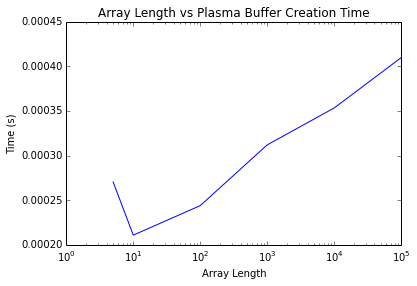

In [72]:
x = [5, 10, 100, 1000, 10000, 100000]
y = [times['buffer_create'] for times in arr_times]

plt.title('Array Length vs Plasma Buffer Creation Time')
plt.xlabel('Array Length')
plt.xscale('log')
plt.ylabel('Time (s)')
plt.plot(x, y)

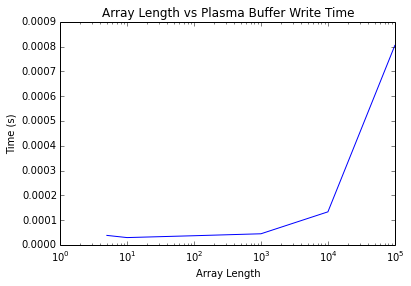

In [73]:
x = [5, 10, 100, 1000, 10000, 100000]
y = [times['write_stream'] for times in arr_times]

plt.title('Array Length vs Plasma Buffer Write Time')
plt.xlabel('Array Length')
plt.xscale('log')
plt.ylabel('Time (s)')
plt.plot(x, y)

## Memory Overhead Experiments

In [254]:
NUM_STRINGS = 131060 # to get exactly 1 MB array
one_meg_arr = np.array([i for i in range(NUM_STRINGS)])
float(sys.getsizeof(one_meg_arr))/1024.0/1024.0

1.0

In [159]:
for i in range(6):
    plasma_client.put(one_meg_arr)

In [160]:
plasma_client.put(one_meg_arr)

ObjectID(c2d2d33241ad32b654ca09d4420044835a573d5c)

In [ ]:
#6 1MB arrays fit in 10MB store -> 6MB fits but 7MB doesn't

In [204]:
NUM_STRINGS = 12788 # to get exactly 100KB array
hundred_kilo_arr = np.array([i for i in range(NUM_STRINGS)])
float(sys.getsizeof(hundred_kilo_arr))/1024.0

100.0

In [205]:
for i in range(75):
    plasma_client.putr (hundred_kilo_arr)

In [209]:
plasma_client.put(hundred_kilo_arr)

ObjectID(321095db89644bbc46b57ad33beef51131bbf2be)

In [ ]:
#79 100KB arrays fit in 10MB store -> 7.9MB fits but 8MB doesn't

In [216]:
NUM_STRINGS = 116 # to get exactly 100KB array
one_kilo_arr = np.array([i for i in range(NUM_STRINGS)])
float(sys.getsizeof(one_kilo_arr))/1024.0

1.0

In [253]:
for i in range(10):
    plasma_client.put(one_kilo_arr)

In [222]:
plasma_client.put(one_kilo_arr)

ObjectID(c9f998ae4b74903963cc14dc3971a90df0f7e68e)

In [ ]:
#4770 1KB arrays fit in 10MB store -> 4.77MB data fits in 10MB but 4.78MB doesn't

In [ ]:
#plot these to compare

## Huge Page Support Experiments

### run `plasma_store -s /tmp/plasma -m 10000000000 -d /tmp/hugepages -h` to start plasma store with huge page support - still working on getting this to work on Mac

In [256]:
NUM_STRINGS = 12788 # to get exactly 100KB array
hundred_kilo_arr = np.array([i for i in range(NUM_STRINGS)])
float(sys.getsizeof(hundred_kilo_arr))/1024.0

100.0

In [ ]:
#TODO: buffer allocation time as a function of page size  - potentially small page size support? - look where page size can be set